#**Desafío 10 - Mecanismos de Votación**

01 de noviembre de 2021

##*Francisca Pinto*

###**Ejercicio 1 - Preparación del ambiente de trabajo**

Comentarios:

1. Se instalan las librerías necesarias para el desarrollo del desafío, y se importa el DataFrame correspondiente.
2. Respecto al archivo de funciones auxiliares, no se pudo importar al tenerlo en el mismo directorio que el presente archivo, por lo que se debió optar por una solución alternativa, subiéndolo directamente para su uso posterior.
3. Luego de importar el DataFrame, se imprime y se revisa la información de <code>.info()</code>.
4. Se realizan los filtros solicitados en el enunciado, y se grafican los grupos de variables.
5. Se realiza el pre-procesamiento con lo siguiente:
* Binarización de la variable objetivo: <code>shares > 1400 -> 1</code>
* Se utiliza la función auxiliar de <code>helpers</code> <code>identify_high_correlations()</code> y se eliminarán variables que participen de correlaciones con <code>|corr| >= 0.8 </code> (positivas o negativas).
* Análisis <code>PCA</code> para tener solo <code>30</code> componentes y realizar reducción de dimensionalidad.

In [ ]:
!pip install ipython-autotime

In [ ]:
#tiempo de ejecución
%load_ext autotime

#dataframe y arrays
import pandas as pd
import numpy as np

#estadística
import scipy.stats as stats

#gráficos

import matplotlib.pyplot as plt
import seaborn as sns

#gama matplotlib para facilitar escritura de código
%matplotlib inline

#separación entrenamiento validación
from sklearn.model_selection import train_test_split, GridSearchCV

#pipeline
from sklearn.pipeline import Pipeline

#clustering
from sklearn.cluster import KMeans

#regresión logística
from sklearn.linear_model import LogisticRegression

#métricas de modelación de clasificación
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report, roc_curve, roc_auc_score

#Árbol de decisión de regresión
from sklearn.tree import DecisionTreeClassifier

#AdaBoost Clasiffier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

#voting
from sklearn.ensemble import VotingClassifier

#dataframe filter
import re

#Principal Component Analysis
from sklearn.decomposition import PCA

#MLXtend
from mlxtend.classifier import EnsembleVoteClassifier

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 31.6 ms (started: 2021-11-01 19:51:26 +00:00)


In [ ]:
#AUX: montar archivos y carpetas desde Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
time: 10.5 ms (started: 2021-11-01 17:34:52 +00:00)


In [ ]:
from google.colab import files

py_path = list(files.upload().values())[0]
open("/content/drive/MyDrive/ADL/3_Intro ML/Desafío 10 - Mecanismos de votación/helpers.py", "wb").write(py_path)

import helpers

Saving helpers.py to helpers (1).py
time: 6.59 s (started: 2021-11-01 17:34:54 +00:00)


In [ ]:
colab_path1 = "/content/drive/MyDrive/ADL/3_Intro ML/Desafío 10 - Mecanismos de votación/Apoyo Desafío - Mecanismos de Votación/OnlineNewsPopularity/OnlineNewsPopularity.csv"

df1 = pd.read_csv(colab_path1)

random_seed = 3748

time: 532 ms (started: 2021-11-01 18:33:29 +00:00)


In [ ]:
df1 #se visualiza para aegurar correcta importación

,url,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,num_videos,average_token_length,num_keywords,data_channel_is_lifestyle,data_channel_is_entertainment,data_channel_is_bus,data_channel_is_socmed,data_channel_is_tech,data_channel_is_world,kw_min_min,kw_max_min,kw_avg_min,kw_min_max,kw_max_max,kw_avg_max,kw_min_avg,kw_max_avg,kw_avg_avg,self_reference_min_shares,self_reference_max_shares,self_reference_avg_sharess,weekday_is_monday,weekday_is_tuesday,weekday_is_wednesday,weekday_is_thursday,weekday_is_friday,weekday_is_saturday,weekday_is_sunday,is_weekend,LDA_00,LDA_01,LDA_02,LDA_03,LDA_04,global_subjectivity,global_sentiment_polarity,global_rate_positive_words,global_rate_negative_words,rate_positive_words,rate_negative_words,avg_positive_polarity,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,shares
0,http://mashable.com/2013/01/07/amazon-instant-...,731.0,12.0,219.0,0.663594,1.0,0.815385,4.0,2.0,1.0,0.0,4.680365,5.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,496.0,496.0,496.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.500331,0.378279,0.040005,0.041263,0.040123,0.521617,0.092562,0.045662,0.013699,0.769231,0.230769,0.378636,0.100000,0.70,-0.350000,-0.600,-0.200000,0.500000,-0.187500,0.000000,0.187500,593
1,http://mashable.com/2013/01/07/ap-samsung-spon...,731.0,9.0,255.0,0.604743,1.0,0.791946,3.0,1.0,1.0,0.0,4.913725,4.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.799756,0.050047,0.050096,0.050101,0.050001,0.341246,0.148948,0.043137,0.015686,0.733333,0.266667,0.286915,0.033333,0.70,-0.118750,-0.125,-0.100000,0.000000,0.000000,0.500000,0.000000,711
2,http://mashable.com/2013/01/07/apple-40-billio...,731.0,9.0,211.0,0.575130,1.0,0.663866,3.0,1.0,1.0,0.0,4.393365,6.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,918.0,918.0,918.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.217792,0.033334,0.033351,0.033334,0.682188,0.702222,0.323333,0.056872,0.009479,0.857143,0.142857,0.495833,0.100000,1.00,-0.466667,-0.800,-0.133333,0.000000,0.000000,0.500000,0.000000,1500
3,http://mashable.com/2013/01/07/astronaut-notre...,731.0,9.0,531.0,0.503788,1.0,0.665635,9.0,0.0,1.0,0.0,4.404896,7.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.028573,0.419300,0.494651,0.028905,0.028572,0.429850,0.100705,0.041431,0.020716,0.666667,0.333333,0.385965,0.136364,0.80,-0.369697,-0.600,-0.166667,0.000000,0.000000,0.500000,0.000000,1200
4,http://mashable.com/2013/01/07/att-u-verse-apps/,731.0,13.0,1072.0,0.415646,1.0,0.540890,19.0,19.0,20.0,0.0,4.682836,7.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,545.0,16000.0,3151.157895,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.028633,0.028794,0.028575,0.028572,0.885427,0.513502,0.281003,0.074627,0.012127,0.860215,0.139785,0.411127,0.033333,1.00,-0.220192,-0.500,-0.050000,0.454545,0.136364,0.045455,0.136364,505
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39639,http://mashable.com/2014/12/27/samsung-app-aut...,8.0,11.0,346.0,0.529052,1.0,0.684783,9.0,7.0,1.0,1.0,4.523121,8.0,0.0,0.0,0.0,0.0,1.0,0.0,-1.0,671.0,173.125,26900.0,843300.0,374962.500000,2514.742857,4004.342857,3031.115764,11400.0,48000.0,37033.333333,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.025038,0.025001,0.151701,0.025000,0.773260,0.482679,0.141964,0.037572,0.014451,0.722222,0.277778,0.333791,0.100000,0.75,-0.260000,-0.500,-0.125000,0.100000,0.000000,0.400000,

time: 133 ms (started: 2021-11-01 17:35:08 +00:00)


In [ ]:
df1.info(verbose = True,
         null_counts = True) #sirve como exploración inicial para revisar en conjunto con visualización de DataFrame

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39644 entries, 0 to 39643
Data columns (total 61 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   url                             39644 non-null  object 
 1    timedelta                      39644 non-null  float64
 2    n_tokens_title                 39644 non-null  float64
 3    n_tokens_content               39644 non-null  float64
 4    n_unique_tokens                39644 non-null  float64
 5    n_non_stop_words               39644 non-null  float64
 6    n_non_stop_unique_tokens       39644 non-null  float64
 7    num_hrefs                      39644 non-null  float64
 8    num_self_hrefs                 39644 non-null  float64
 9    num_imgs                       39644 non-null  float64
 10   num_videos                     39644 non-null  float64
 11   average_token_length           39644 non-null  float64
 12   num_keywords                   

In [ ]:
df1.columns = [i.replace(" ", "") for i in df1.columns]

qnty = df1.filter(regex = "^n_",
                  axis = 1)

channel = df1.filter(regex = "^data_",
                     axis = 1)

days = df1.filter(regex = re.compile("weekday|weekend"),
                  axis = 1)

sentiments = df1.filter(regex = re.compile("negative|positive|subjectivity"),
                        axis = 1)

lda = df1.filter(regex = "^LDA_\d",
                 axis = 1)

keywords = df1.filter(regex = "^kw_",
                      axis = 1)

time: 25.8 ms (started: 2021-11-01 18:33:35 +00:00)


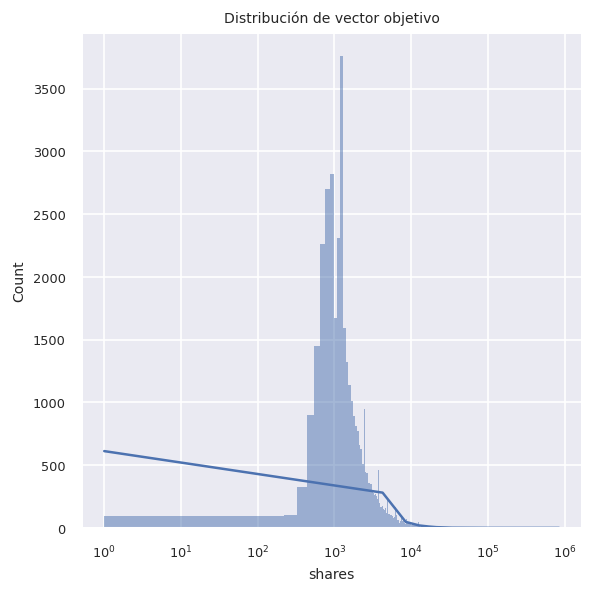

time: 24 s (started: 2021-11-01 22:53:03 +00:00)


In [ ]:
sns.set(font_scale = 0.7) #escalar fuente para acomodar a gráfico
plt.rcParams["figure.figsize"] = (5, 5) #escalar gráficos
plt.rcParams["figure.dpi"] = 120 #DPI gráficos (también modifica tamaño)

ax = sns.histplot(df1["shares"], kde = True)
plt.xscale("log")
plt.title(f"Distribución de vector objetivo")

plt.tight_layout()
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn

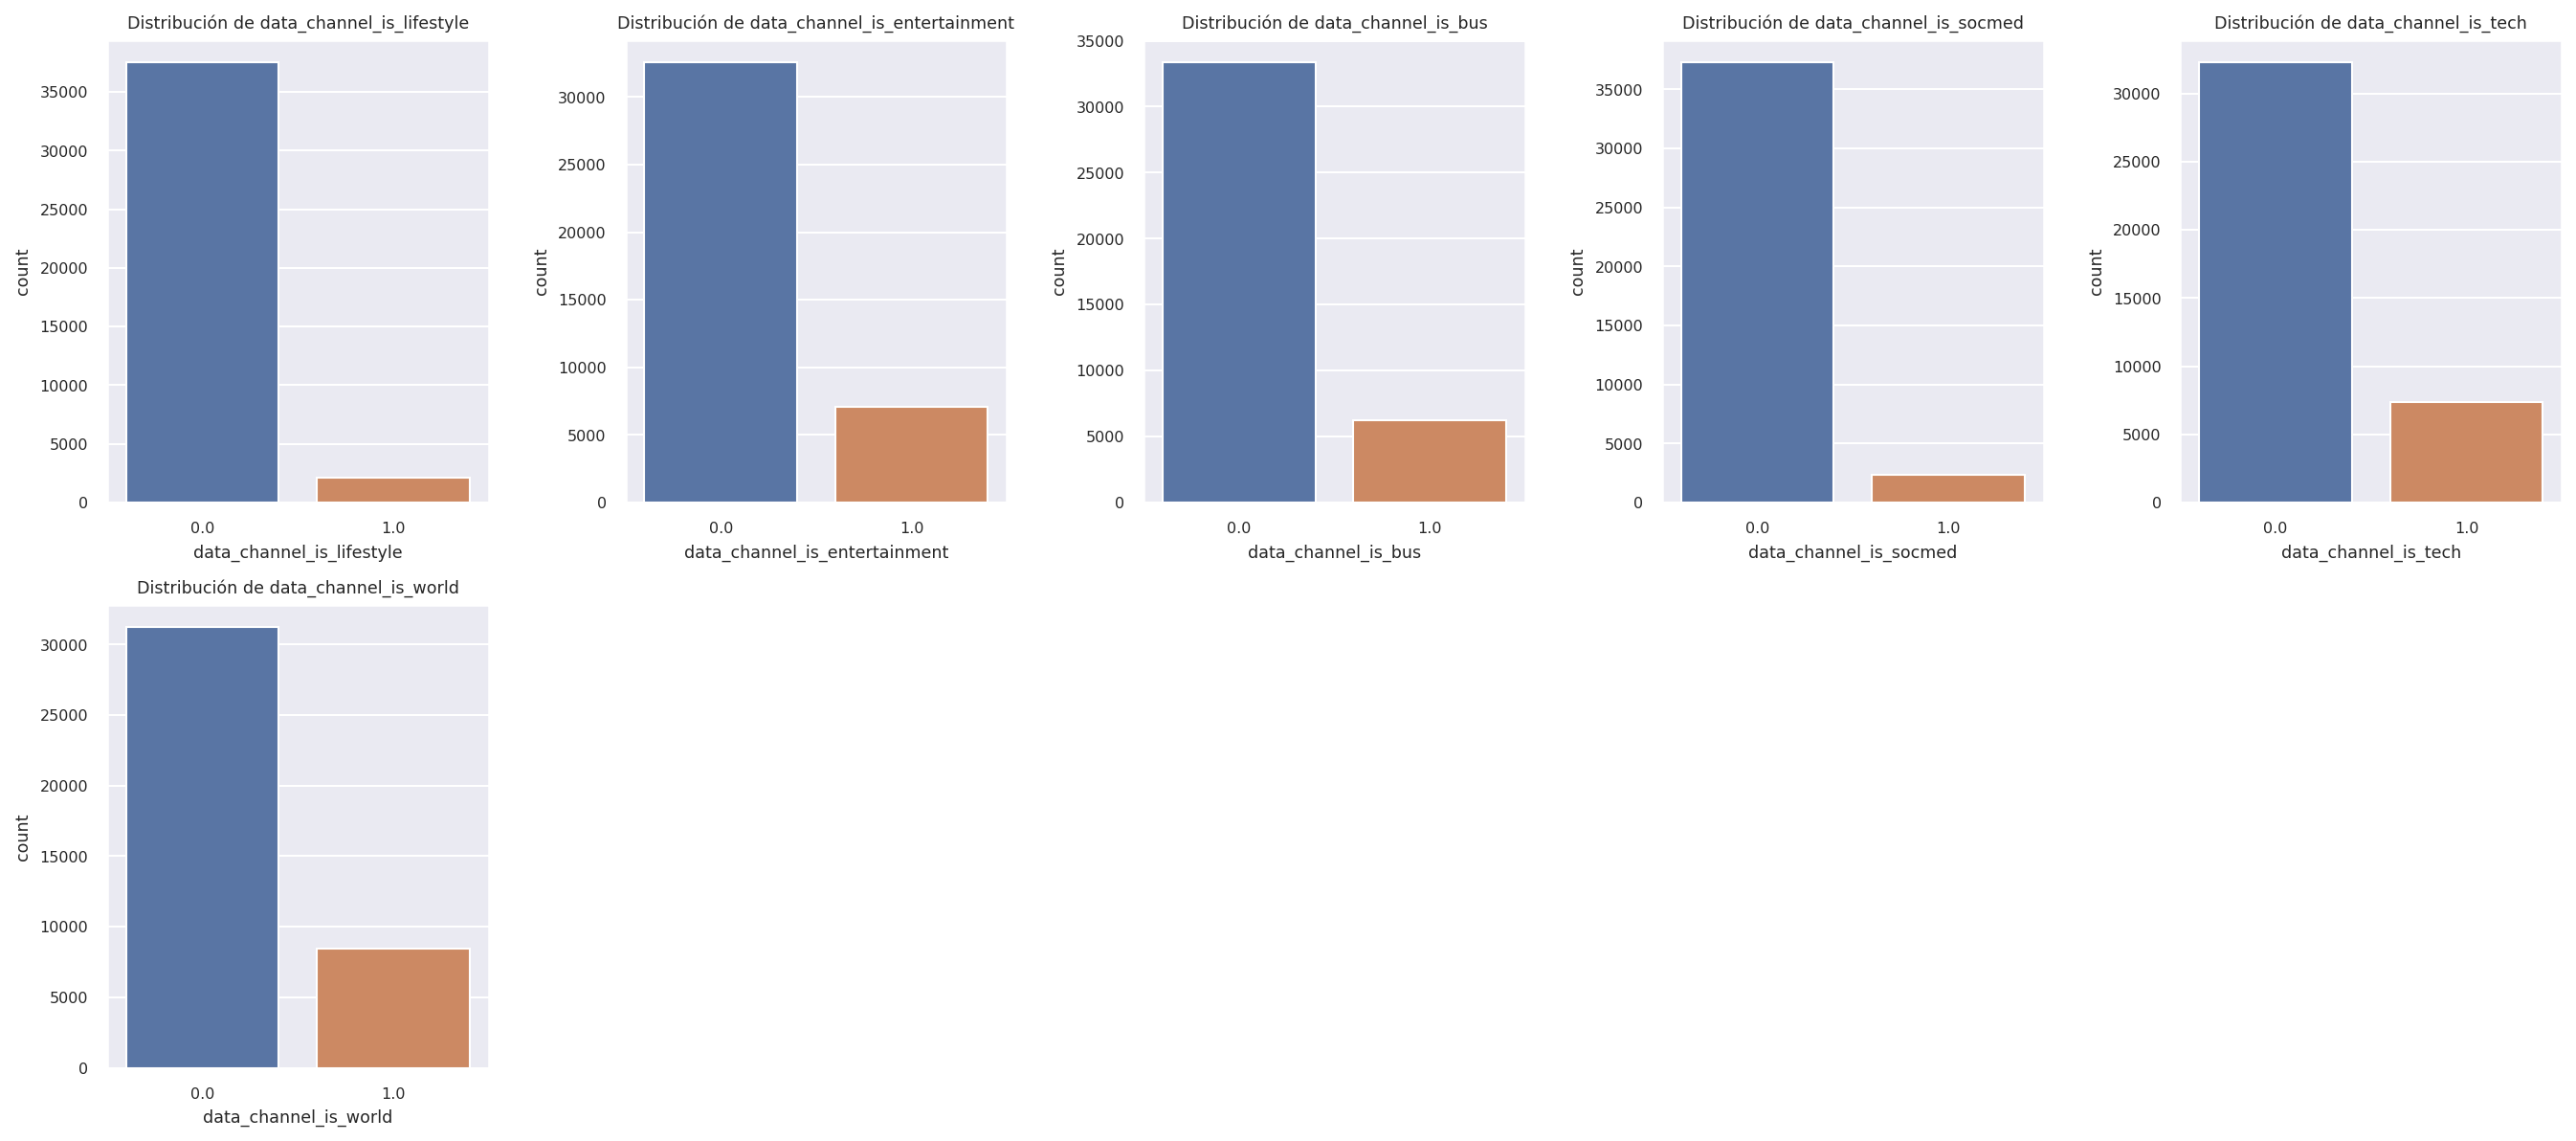

time: 1.55 s (started: 2021-11-01 17:35:27 +00:00)


In [ ]:
sns.set(font_scale = 0.7) #escalar fuente para acomodar a gráfico
plt.rcParams["figure.figsize"] = (18, 8) #escalar gráficos
plt.rcParams["figure.dpi"] = 150 #DPI gráficos (también modifica tamaño)

for index, attribute in enumerate(channel):

  plt.subplot(2, 5, index + 1)
  ax = sns.countplot(channel[attribute])
  plt.title(f"Distribución de {attribute}")

plt.tight_layout()
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn

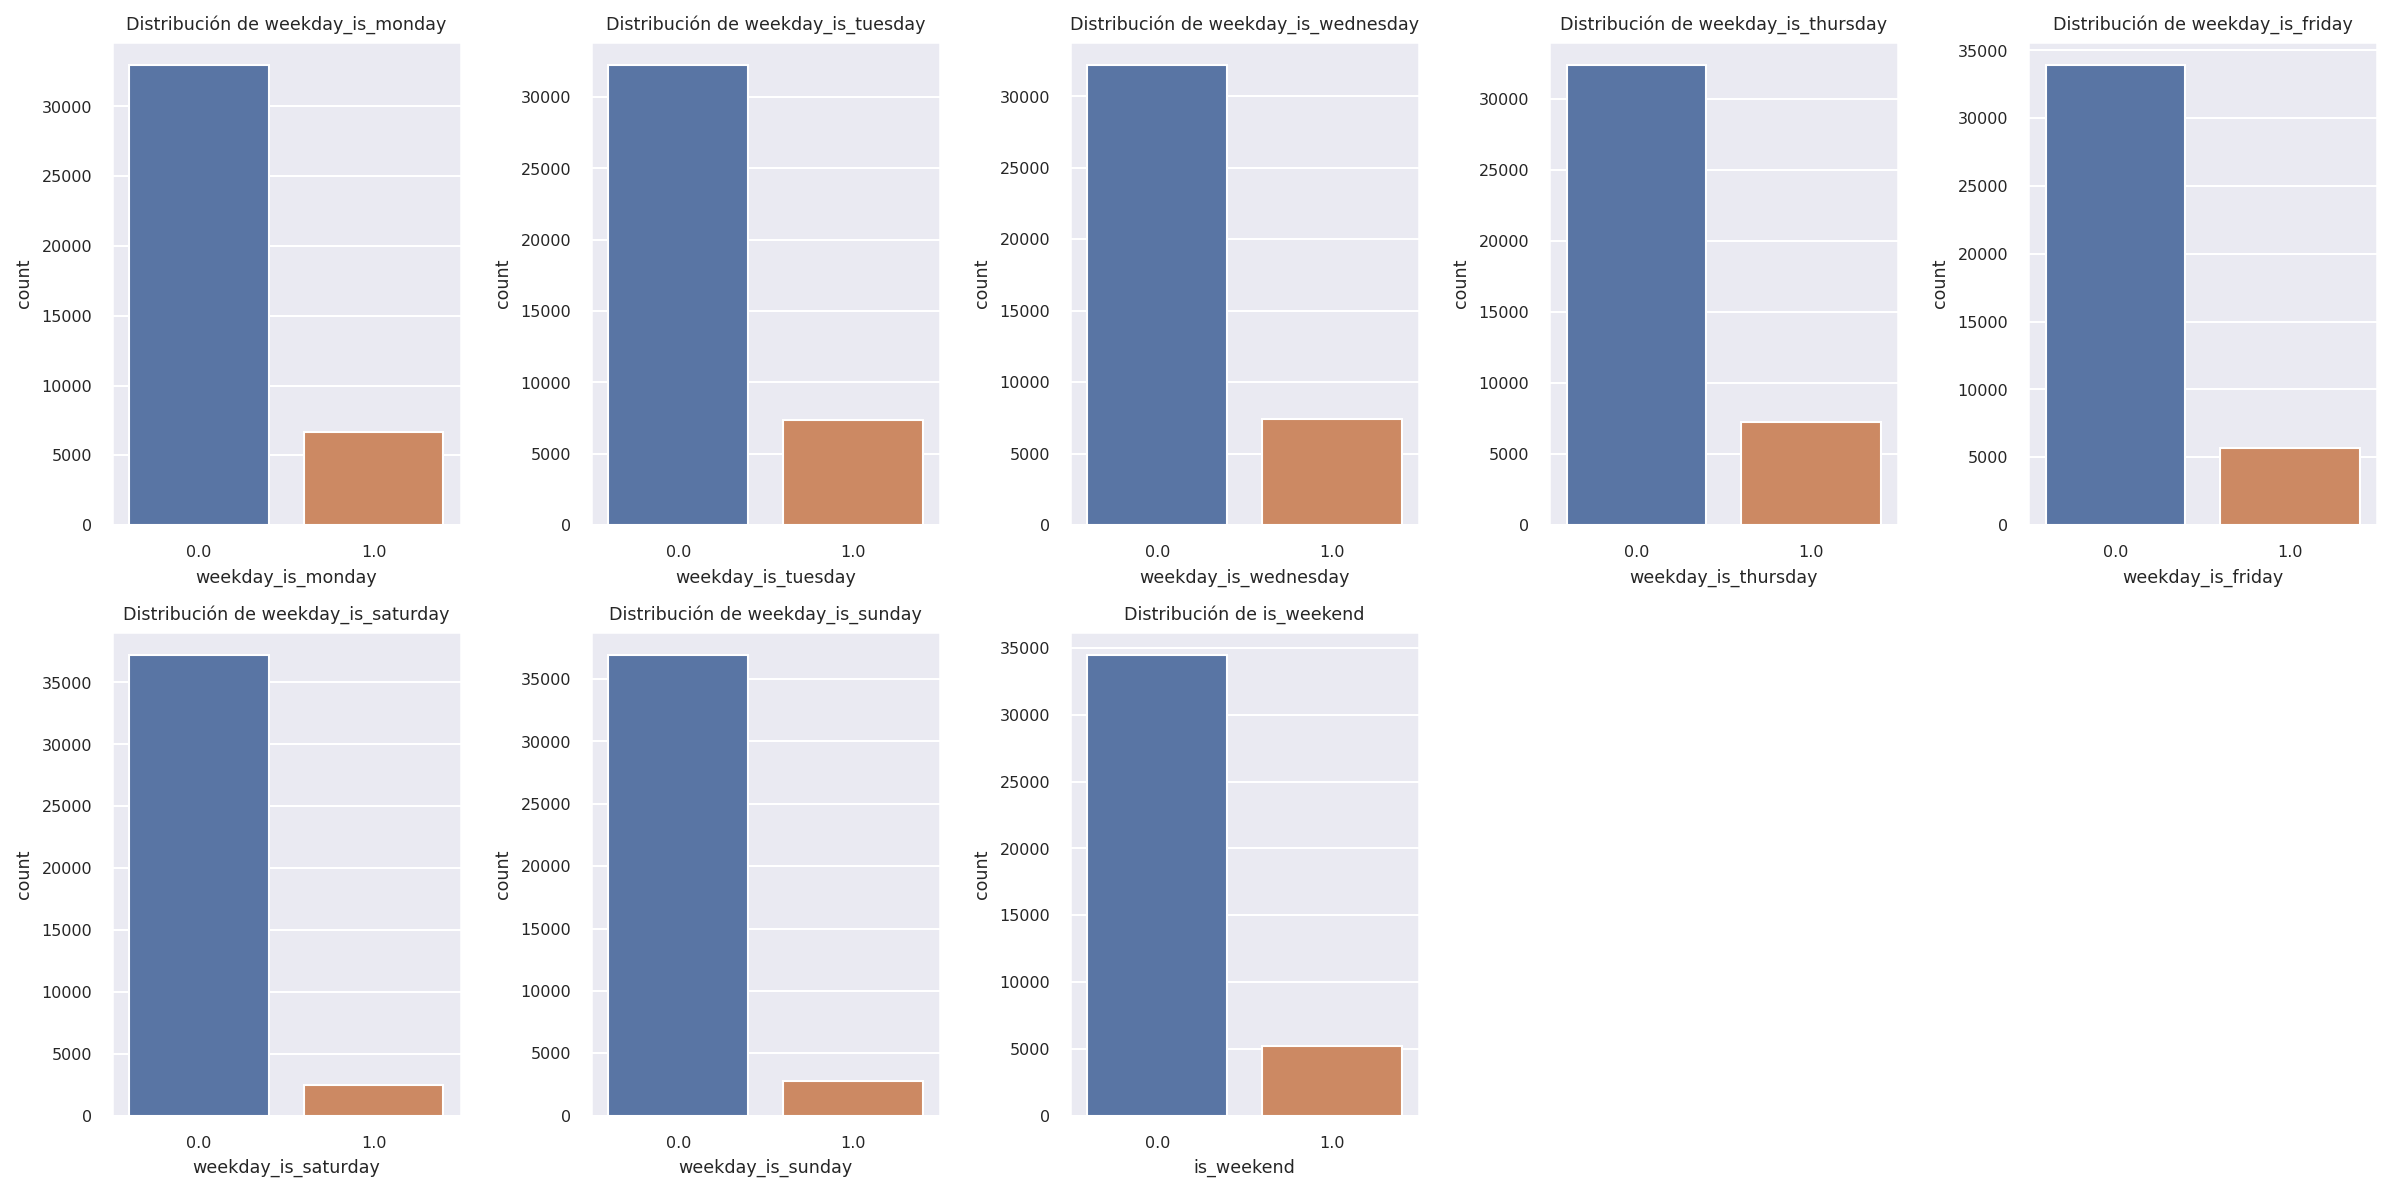

time: 1.61 s (started: 2021-11-01 17:35:31 +00:00)


In [ ]:
sns.set(font_scale = 0.7) #escalar fuente para acomodar a gráfico
plt.rcParams["figure.figsize"] = (16, 8) #escalar gráficos
plt.rcParams["figure.dpi"] = 150 #DPI gráficos (también modifica tamaño)

for index, attribute in enumerate(days):

  plt.subplot(2, 5, index + 1)
  ax = sns.countplot(days[attribute])
  plt.title(f"Distribución de {attribute}")

plt.tight_layout()
plt.show()

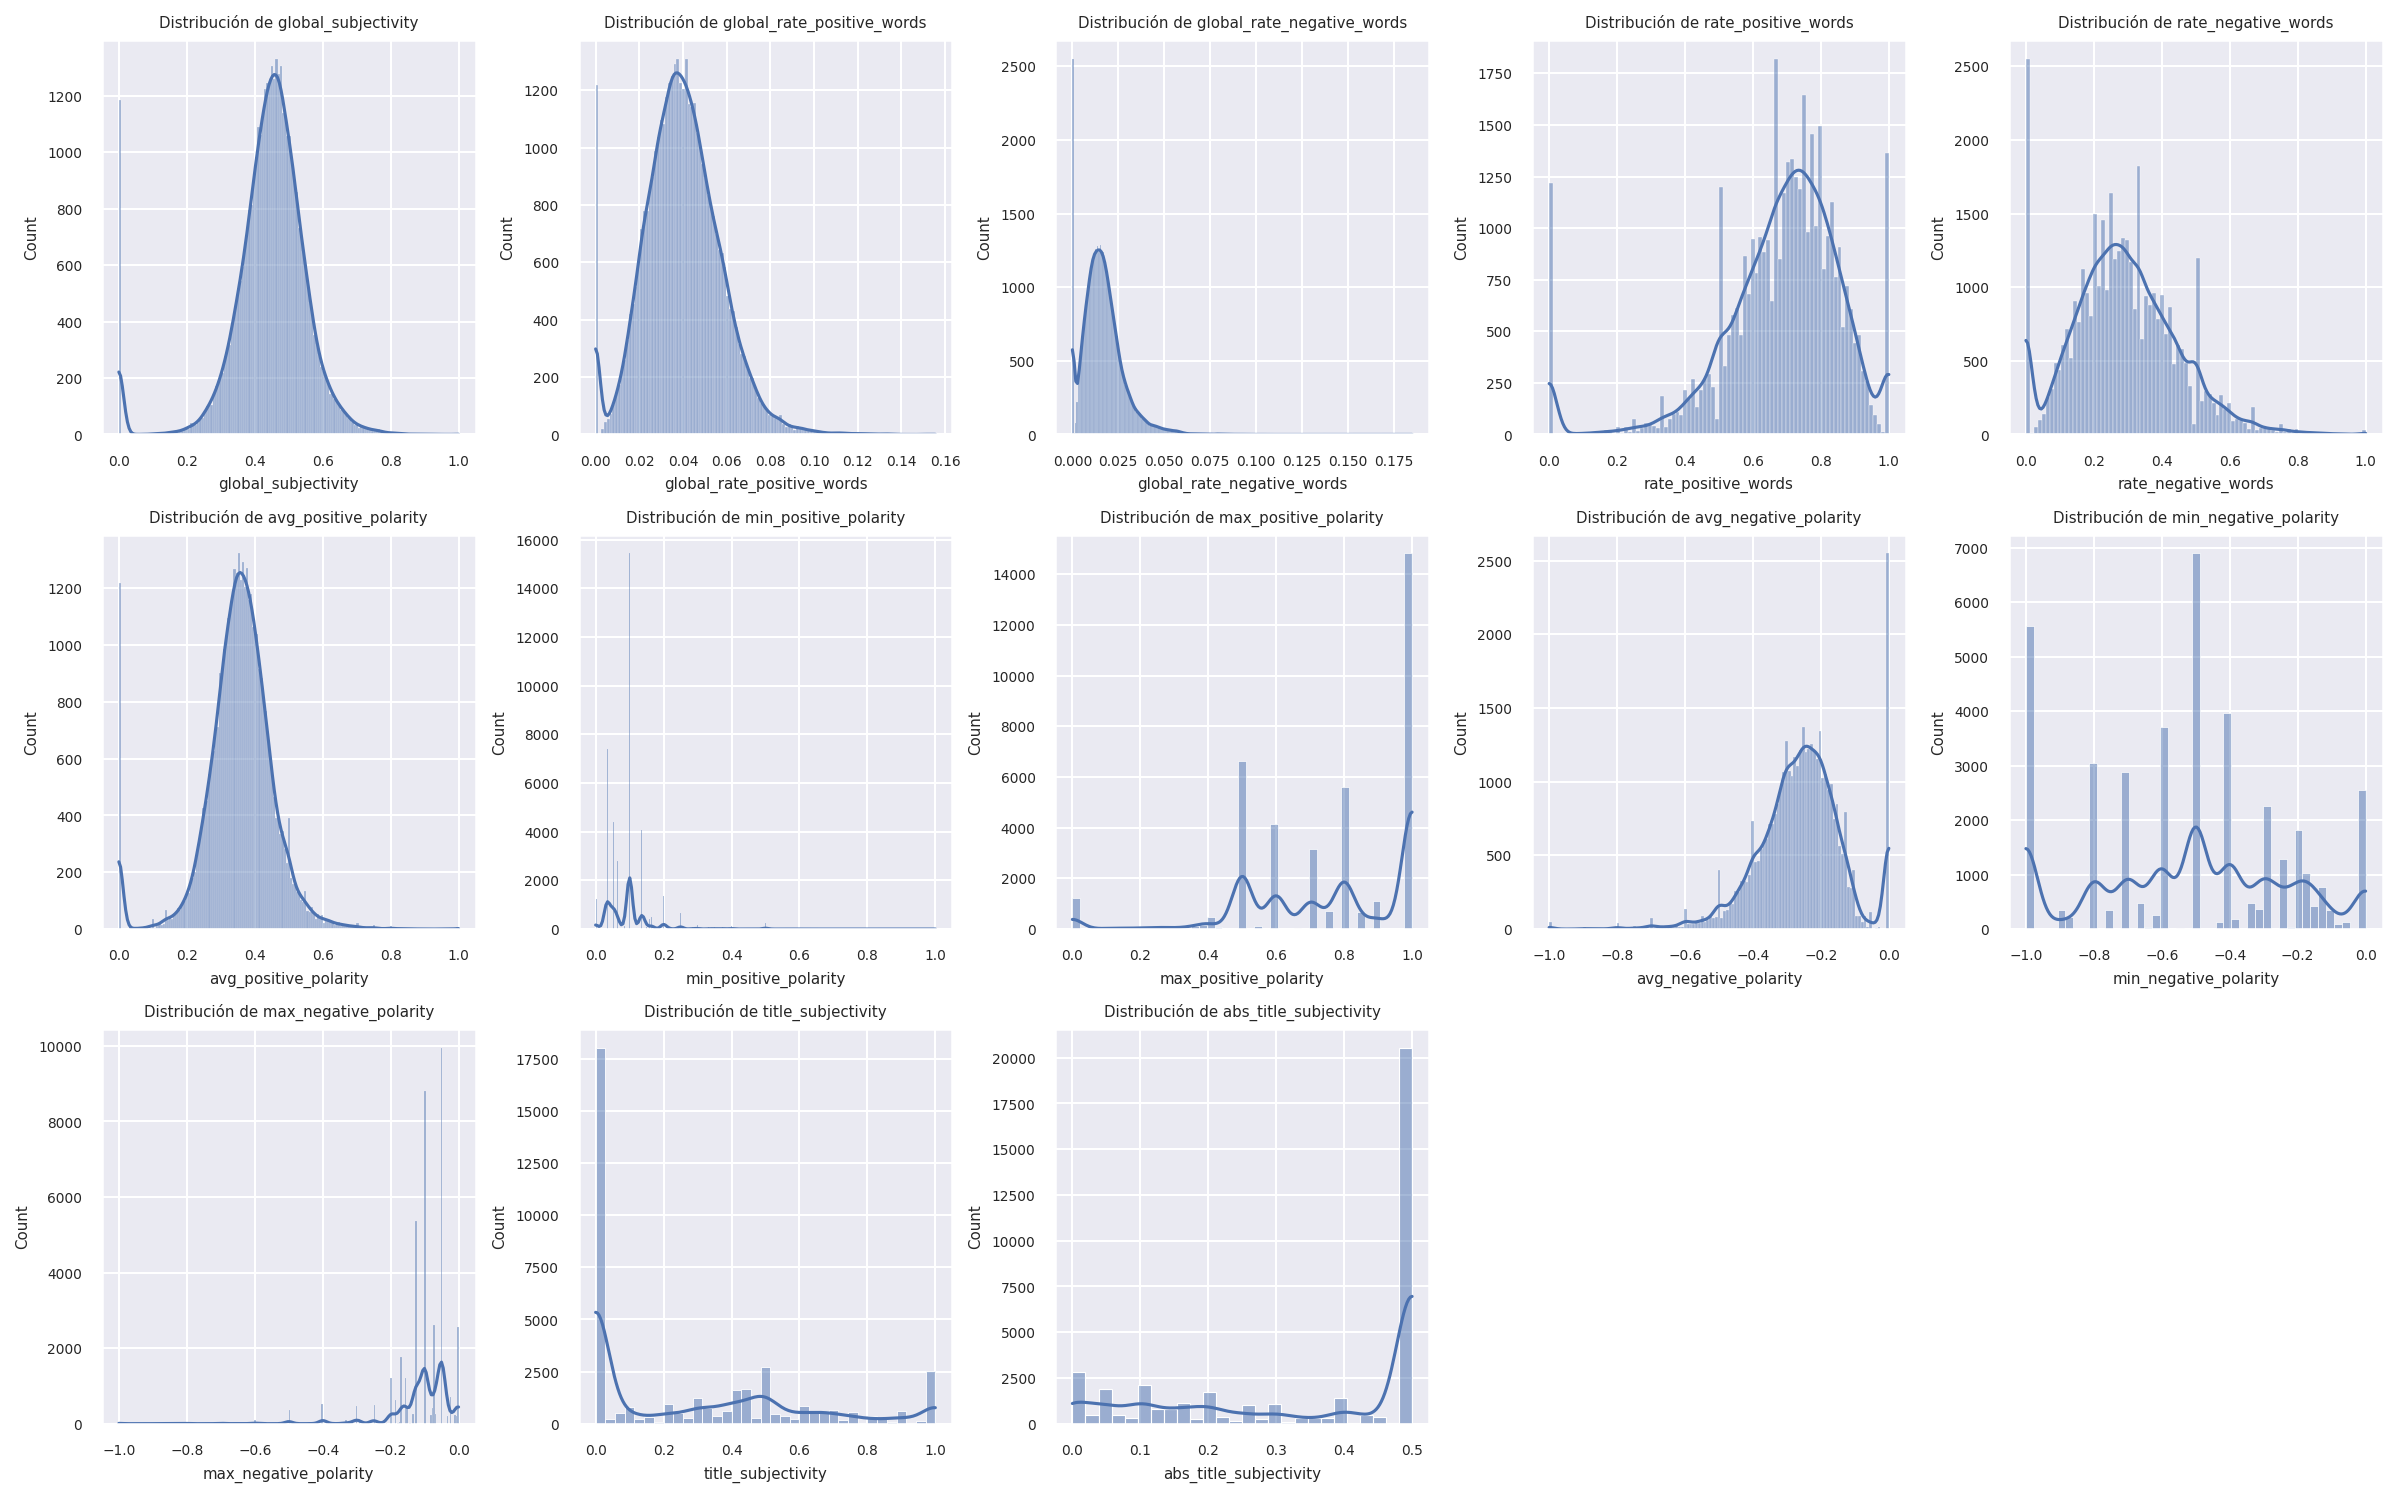

time: 12.5 s (started: 2021-11-01 21:52:25 +00:00)


In [ ]:
sns.set(font_scale = 0.6) #escalar fuente para acomodar a gráfico
plt.rcParams["figure.figsize"] = (16, 10) #escalar gráficos
plt.rcParams["figure.dpi"] = 150 #DPI gráficos (también modifica tamaño)

for index, attribute in enumerate(sentiments):
  
  plt.subplot(3, 5, index + 1)

  if len(sentiments[attribute].value_counts()) > 30:
    ax = sns.histplot(sentiments[attribute], kde = True)
    plt.title(f"Distribución de {attribute}")

  else:
    ax = sns.countplot(x = sentiments[attribute])
    plt.title(f"Distribución de {attribute}")
  
plt.tight_layout()
plt.show()    

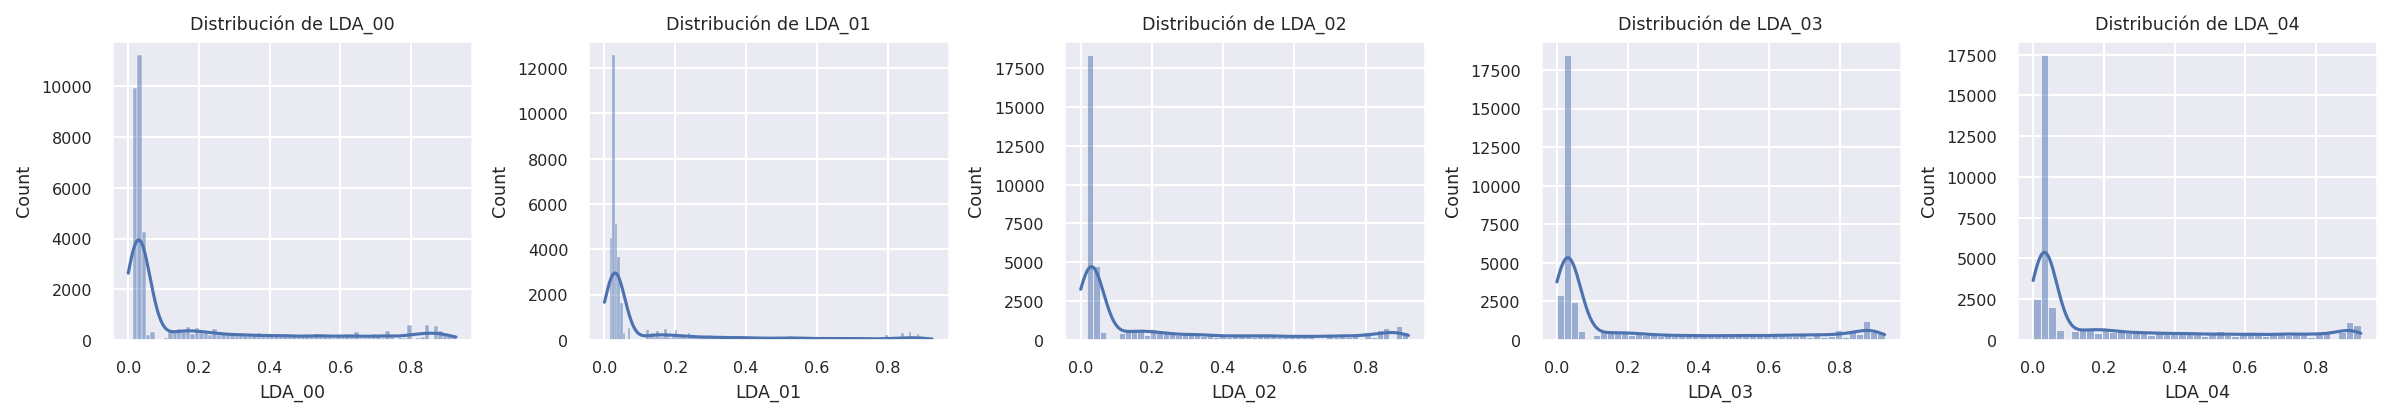

time: 4.17 s (started: 2021-11-01 17:36:06 +00:00)


In [ ]:
sns.set(font_scale = 0.7) #escalar fuente para acomodar a gráfico
plt.rcParams["figure.figsize"] = (16, 10) #escalar gráficos
plt.rcParams["figure.dpi"] = 150 #DPI gráficos (también modifica tamaño)

for index, attribute in enumerate(lda):

  plt.subplot(4, 5, index + 1)
  ax = sns.histplot(lda[attribute], kde = True)
  plt.title(f"Distribución de {attribute}")

plt.tight_layout()
plt.show()

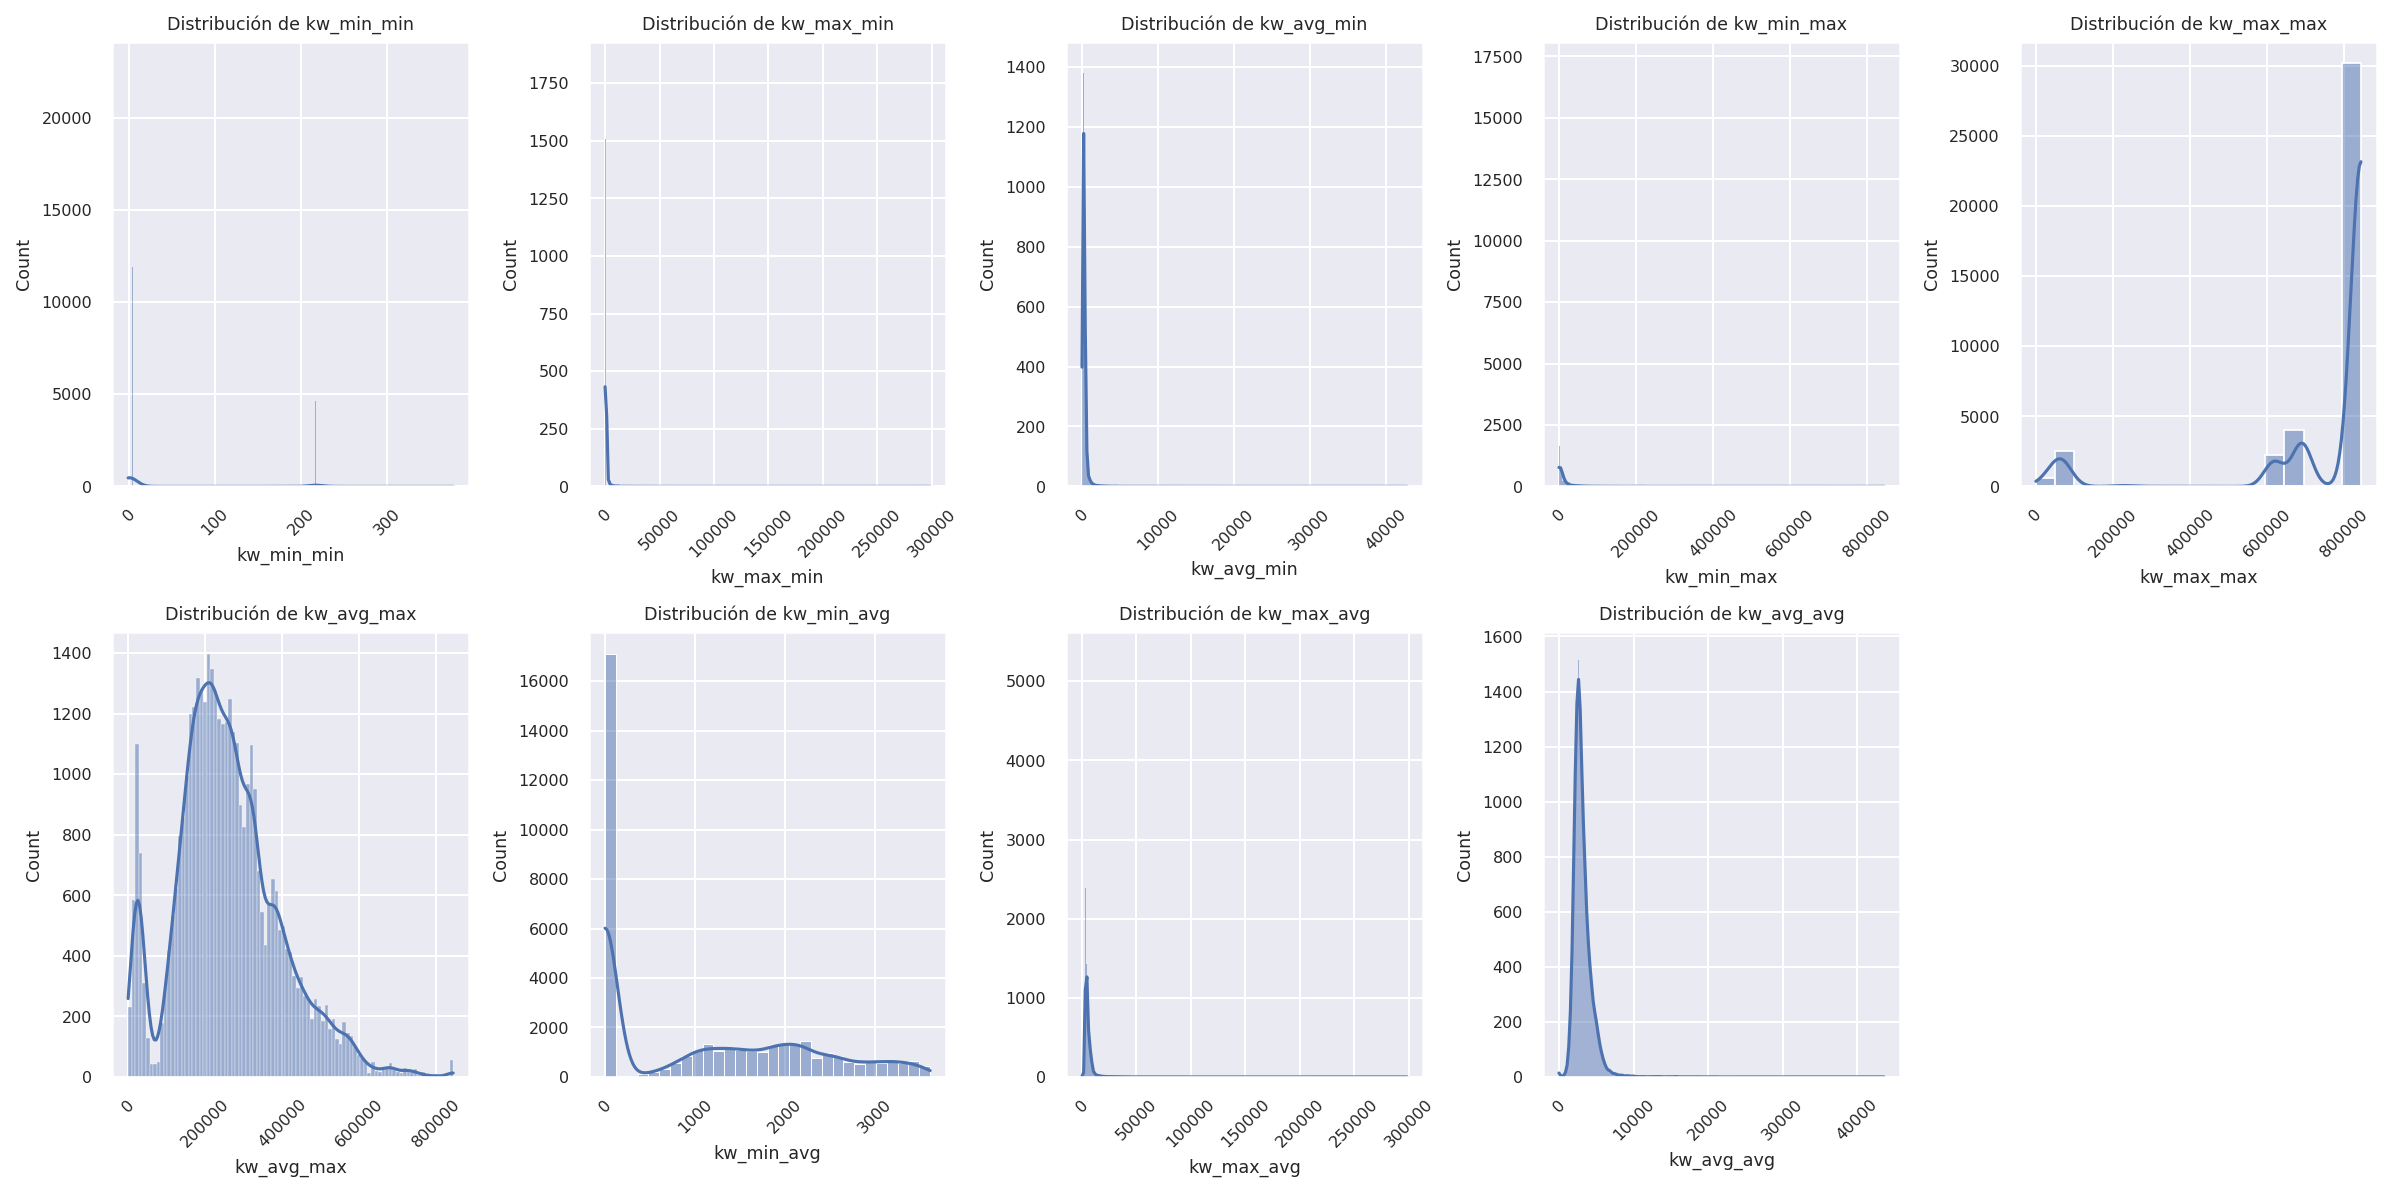

time: 45.9 s (started: 2021-11-01 22:17:36 +00:00)


In [ ]:
sns.set(font_scale = 0.7) #escalar fuente para acomodar a gráfico
plt.rcParams["figure.figsize"] = (16, 8) #escalar gráficos
plt.rcParams["figure.dpi"] = 150 #DPI gráficos (también modifica tamaño)

for index, attribute in enumerate(keywords):

  plt.subplot(2, 5, index + 1)
  ax = sns.histplot(keywords[attribute], kde = True)
  plt.xticks(rotation = 45)
  plt.title(f"Distribución de {attribute}")

plt.tight_layout()
plt.show()

In [ ]:
sns.set(font_scale = 0.7) #escalar fuente para acomodar a gráfico
plt.rcParams["figure.figsize"] = (18, 8) #escalar gráficos
plt.rcParams["figure.dpi"] = 150 #DPI gráficos (también modifica tamaño)

for index, attribute in enumerate(qnty):

  plt.subplot(2, 5, index + 1)
  ax = sns.histplot(qnty[attribute], kde = True)
  plt.title(f"Distribución de {attribute}")

plt.tight_layout()
plt.show()

Comentarios:

1. Respecto a cada grupo de variables, se tiene:

- **shares**: inicialmente se graficó con el eje X en distribución lineal pero los valores no eran claros, por lo que se decidió modificar la escala del eje. Los valores se concentran en el área central, cercano a los 1000 <code>shares</code>.

- **channel**: la distribución es desigual en las variables, ya que es una descomposición de una sola (variable categórica), relativa a la categoría del blog del cual se extrajo el texto. De todas estas opciones, la que tiene más registros en la categoría "world".

- **days**: como en el caso anterior, este grupo de atributos también es una descomposición de una variable categórica que muestra el día de la semana en el que se publicó el artículo. Se observa una distribución pareja en días hábiles, con una menor proporción de los días sábado y domingo. Junto con ello existe una variable binaria "is_weekend" que suma las publicaciones de los fines de semana.

- **sentiments**: este conjunto de variables es una serie de atributos continuos. A pesar de que se trató de graficar algunas variables de forma continua, se detectó que la cantidad de valores distintos que presentan dificultaba tal representación (existe una gran cantidad de valores distintos que, al ser graficados en un <code>countplot</code>, no tienen una mejor representación que en un <code>hisplot</code>).

Existen variables tales como <code>global_subjectivity</code>, <code>global_rate_positive_words</code>, <code>global_rate_negative_words</code>, <code>rate_positive_words</code>, <code>rate_negative_words</code>, <code>avg_positive_polarity</code> y <code>avg_negative_polarity</code> que tienen gran diversidad de valores, por lo que pueden observarse distribuciones fluidas a lo largo del eje <code>X</code>, y junto con ello se observa una concentración importante de valores nulos.

En otros casos, como <code>min_positive_polarity</code>, <code>max_positive_polarity</code>, <code>min_relative_polarity</code>, <code>max_negative_polarity</code>, <code>title_subjectivity</code> y <code>abs_title_subjectivity</code> la cantidad de valores es más baja y las curvas de distribución no son claras, observando en algunas de estas variables sesgos importantes en torno a algunos valores, como por ejemplo, 0.0 o 0.5 o -0.5.

- **lda**: nuevamente estos atributos son una expansión de una variable categórica, luego de que los textos fueran procesados por un algoritmo LDA (Latent Dirichlet Allocation), mostrando la probabilidad de pertenencia a cada grupo (de los 5 creados). Las distribuciones tienen algo sesgo en 0.0 y posteriormente la cantidad de datos en el eje X es bastante baja.

- **keywords**: las distribuciones son poco claras y existen solo dos variables con histogramas mejor definidos: <code>kw_avg_max</code> y <code>kw_avg_avg</code>. En los otros casos se observan curvas con concentraciones importantes en 0 en el eje X, y en el resto de posibles valores de cada indicador la frecuencia es casi nula.

------------------
2. Ahora se aplicará la función <code>indentify_high_correlations</code>.


In [ ]:
helpers.identify_high_correlations(qnty, 0.8)

,variable,var2,value
17,n_non_stop_words,n_unique_tokens,0.999572
22,n_non_stop_unique_tokens,n_unique_tokens,0.999852
23,n_non_stop_unique_tokens,n_non_stop_words,0.999532


time: 38.4 ms (started: 2021-11-01 17:38:24 +00:00)


In [ ]:
helpers.identify_high_correlations(channel, 0.8)

,variable,var2,value


time: 39.8 ms (started: 2021-11-01 17:38:24 +00:00)


In [ ]:
helpers.identify_high_correlations(days, 0.8)

,variable,var2,value
62,is_weekend,weekday_is_sunday,0.701648


time: 43.1 ms (started: 2021-11-01 17:38:24 +00:00)


In [ ]:
helpers.identify_high_correlations(sentiments, 0.8)

,variable,var2,value
54,rate_negative_words,global_rate_negative_words,0.779556
96,max_positive_polarity,avg_positive_polarity,0.703558
125,min_negative_polarity,avg_negative_polarity,0.748896


time: 66 ms (started: 2021-11-01 17:38:25 +00:00)


In [ ]:
helpers.identify_high_correlations(lda, 0.8)

,variable,var2,value


time: 39.6 ms (started: 2021-11-01 17:38:25 +00:00)


In [ ]:
helpers.identify_high_correlations(keywords, 0.9)

,variable,var2,value
19,kw_avg_min,kw_max_min,0.940529
36,kw_max_max,kw_min_min,-0.857226
79,kw_avg_avg,kw_max_avg,0.811864


time: 55.2 ms (started: 2021-11-01 17:38:25 +00:00)


Comentarios:

1. **Columnas a eliminar**

Las columnas que serán incorporadas a <code>.drop()</code> son:

<code>qnty</code>
* n_unique_tokens
* n_non_stop_words

<code>channel</code>
* No se detectan correlaciones que superen el umbral de 0.8 (ni menores tampoco)

<code>days</code>
* weekend_is_sunday

<code>sentiments</code>
* No hay correlaciones sobre el umbral por lo que no se eliminarán columnas de este grupo

<code>lda</code>
* No se detectan correlaciones que superen el umbral de 0.8 (ni menores tampoco)

<code>keywords</code>
* kw_max_min
* kw_min_min
* kw_max_avg

In [ ]:
df12 = df1.drop(columns = ["url",
                           "timedelta", #primeras dos columnas no son atributos a considerar
                           "n_unique_tokens",
                           "n_non_stop_words",
                           "weekday_is_sunday",
                           "kw_max_min",
                           "kw_min_min",
                           "kw_max_avg"])

time: 12.5 ms (started: 2021-11-01 18:34:34 +00:00)


In [ ]:
df12["shares_bin"] = np.where(df12["shares"] > 1400, 1, 0)

time: 7.8 ms (started: 2021-11-01 18:34:41 +00:00)


In [ ]:
df12.drop(columns = "shares",
          inplace = True)

time: 16.2 ms (started: 2021-11-01 18:34:44 +00:00)


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


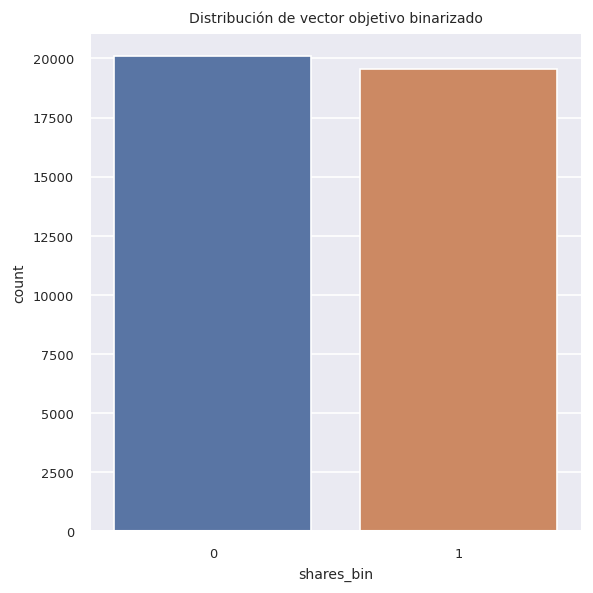

time: 272 ms (started: 2021-11-01 22:55:51 +00:00)


In [ ]:
sns.set(font_scale = 0.7) #escalar fuente para acomodar a gráfico
plt.rcParams["figure.figsize"] = (5, 5) #escalar gráficos
plt.rcParams["figure.dpi"] = 120 #DPI gráficos (también modifica tamaño)

ax = sns.countplot(df12["shares_bin"])
plt.title(f"Distribución de vector objetivo binarizado")

plt.tight_layout()
plt.show()

Comentarios:

1. La distribución de la variable objetivo binarizada es equilibrada, facilitando el trabajo posterior de los modelos integrantes del comité.

In [ ]:
df12 #se muestra para corroborar procesamiento

,n_tokens_title,n_tokens_content,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,num_videos,average_token_length,num_keywords,data_channel_is_lifestyle,data_channel_is_entertainment,data_channel_is_bus,data_channel_is_socmed,data_channel_is_tech,data_channel_is_world,kw_avg_min,kw_min_max,kw_max_max,kw_avg_max,kw_min_avg,kw_avg_avg,self_reference_min_shares,self_reference_max_shares,self_reference_avg_sharess,weekday_is_monday,weekday_is_tuesday,weekday_is_wednesday,weekday_is_thursday,weekday_is_friday,weekday_is_saturday,is_weekend,LDA_00,LDA_01,LDA_02,LDA_03,LDA_04,global_subjectivity,global_sentiment_polarity,global_rate_positive_words,global_rate_negative_words,rate_positive_words,rate_negative_words,avg_positive_polarity,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,shares_bin
0,12.0,219.0,0.815385,4.0,2.0,1.0,0.0,4.680365,5.0,0.0,1.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.000000,0.000000,0.000000,496.0,496.0,496.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.500331,0.378279,0.040005,0.041263,0.040123,0.521617,0.092562,0.045662,0.013699,0.769231,0.230769,0.378636,0.100000,0.70,-0.350000,-0.600,-0.200000,0.500000,-0.187500,0.000000,0.187500,0
1,9.0,255.0,0.791946,3.0,1.0,1.0,0.0,4.913725,4.0,0.0,0.0,1.0,0.0,0.0,0.0,0.000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.799756,0.050047,0.050096,0.050101,0.050001,0.341246,0.148948,0.043137,0.015686,0.733333,0.266667,0.286915,0.033333,0.70,-0.118750,-0.125,-0.100000,0.000000,0.000000,0.500000,0.000000,0
2,9.0,211.0,0.663866,3.0,1.0,1.0,0.0,4.393365,6.0,0.0,0.0,1.0,0.0,0.0,0.0,0.000,0.0,0.0,0.000000,0.000000,0.000000,918.0,918.0,918.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.217792,0.033334,0.033351,0.033334,0.682188,0.702222,0.323333,0.056872,0.009479,0.857143,0.142857,0.495833,0.100000,1.00,-0.466667,-0.800,-0.133333,0.000000,0.000000,0.500000,0.000000,1
3,9.0,531.0,0.665635,9.0,0.0,1.0,0.0,4.404896,7.0,0.0,1.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.028573,0.419300,0.494651,0.028905,0.028572,0.429850,0.100705,0.041431,0.020716,0.666667,0.333333,0.385965,0.136364,0.80,-0.369697,-0.600,-0.166667,0.000000,0.000000,0.500000,0.000000,0
4,13.0,1072.0,0.540890,19.0,19.0,20.0,0.0,4.682836,7.0,0.0,0.0,0.0,0.0,1.0,0.0,0.000,0.0,0.0,0.000000,0.000000,0.000000,545.0,16000.0,3151.157895,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.028633,0.028794,0.028575,0.028572,0.885427,0.513502,0.281003,0.074627,0.012127,0.860215,0.139785,0.411127,0.033333,1.00,-0.220192,-0.500,-0.050000,0.454545,0.136364,0.045455,0.136364,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39639,11.0,346.0,0.684783,9.0,7.0,1.0,1.0,4.523121,8.0,0.0,0.0,0.0,0.0,1.0,0.0,173.125,26900.0,843300.0,374962.500000,2514.742857,3031.115764,11400.0,48000.0,37033.333333,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.025038,0.025001,0.151701,0.025000,0.773260,0.482679,0.141964,0.037572,0.014451,0.722222,0.277778,0.333791,0.100000,0.75,-0.260000,-0.500,-0.125000,0.100000,0.000000,0.400000,0.000000,1
39640,12.0,328.0,0.885057,9.0,7.0,3.0,48.0,4.405488,7.0,0.0,0.0,0.0,1.0,0.0,0.0,184.000,6500.0,843300.0,192985.714286,1664.267857,3411.660830,2100.0,2100.0,2100.000000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.029349,0.028575,0.231866,0.681635,0.028575,0.564374,0.194249,0.039634,0.009146,0.812500,0.187500,0.374825,0.136364,0.70,-0.211111,-0.400,-0.100000,0.300000,1.000000,0.200000,1.000000,1
39641,10.0,442.0,0.644128,24.0,1.0,12.0,1.0,5.076923,8.0,0.0,0.0,0.0,0.0,0.0,0.0,168.250,6200.0,843300.0,295850.000000,1753.882353,4206.439195,1400.0,1400.0,1400.000000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.159004,0.025025,0.025207,0.643794,0.146970,0.510296,0.024609,0.033937,0.024887,0.576923,

time: 112 ms (started: 2021-11-01 18:34:47 +00:00)


Comentarios:

1. Ahora se realizará <code>PCA</code> para realizar la reducción de dimensionalidad.

In [ ]:
pca_ = PCA(n_components = 30,
           random_state = random_seed)
pca_vars = pca_.fit_transform(df12.drop(columns = "shares_bin"))

time: 733 ms (started: 2021-11-01 22:41:30 +00:00)


In [ ]:
print("Reducción de dimensionalidad Principal Component Analysis (PCA)",
      "\n",
      f"Cantidad de componentes: {pca_.n_components}",
      "\n",
      f"Varianza del DataFrame explicada por los componentes de modelo {sum(pca_.explained_variance_ratio_)}.",
      "\n",
      "---------",
      "\n")

Reducción de dimensionalidad Principal Component Analysis (PCA) 
 Cantidad de componentes: 30 
 Varianza del DataFrame explicada por los componentes de modelo 0.9999999999949505. 
 --------- 

time: 10.7 ms (started: 2021-11-01 22:41:36 +00:00)


Comentarios:
1. Los 30 componentes del análisis PCA explican prácticamente la totalidad de la varianza de los atributos del DataFrame.
2. Se creará un DataFrame con la información procesada por <code>PCA</code> y el vector objetivo binarizado.
3. Ahora se realiza la separación de muestras para realizar los modelos que formarán parte del Comité de Votación, a partir de los nuevos atributos creados en <code>PCA</code>.

###**Ejercicio 2 - Evaluación de modelos individuales**

In [ ]:
df2_dict = {"Component 1" : pca_vars[:, 0],
            "Component 2" : pca_vars[:, 1],
            "Component 3" : pca_vars[:, 2],
            "Component 4" : pca_vars[:, 3],
            "Component 5" : pca_vars[:, 4],
            "Component 6" : pca_vars[:, 5],
            "Component 7" : pca_vars[:, 6],
            "Component 8" : pca_vars[:, 7],
            "Component 9" : pca_vars[:, 8],
            "Component 10" : pca_vars[:, 9],
            "Component 11" : pca_vars[:, 10],
            "Component 12" : pca_vars[:, 11],
            "Component 13" : pca_vars[:, 12],
            "Component 14" : pca_vars[:, 13],
            "Component 15" : pca_vars[:, 14],
            "Component 16" : pca_vars[:, 15],
            "Component 17" : pca_vars[:, 16],
            "Component 18" : pca_vars[:, 17],
            "Component 19" : pca_vars[:, 18],
            "Component 20" : pca_vars[:, 19],
            "Component 21" : pca_vars[:, 20],
            "Component 22" : pca_vars[:, 21],
            "Component 23" : pca_vars[:, 22],
            "Component 24" : pca_vars[:, 23],
            "Component 25" : pca_vars[:, 24],
            "Component 26" : pca_vars[:, 25],
            "Component 27" : pca_vars[:, 26],
            "Component 28" : pca_vars[:, 27],
            "Component 29" : pca_vars[:, 28],
            "Component 30" : pca_vars[:, 29],
            }

time: 25.3 ms (started: 2021-11-01 22:31:00 +00:00)


In [ ]:
df2 = pd.DataFrame(df2_dict)

time: 18.4 ms (started: 2021-11-01 22:31:17 +00:00)


In [ ]:
df3 = pd.merge(left = df2,
               right = df12["shares_bin"],
               how = "outer",
               left_index = True,
               right_index = True)

time: 18.2 ms (started: 2021-11-01 22:44:44 +00:00)


In [ ]:
df3 #se imprime para corroborar correcto procesamiento

,Component 1,Component 2,Component 3,Component 4,Component 5,Component 6,Component 7,Component 8,Component 9,Component 10,Component 11,Component 12,Component 13,Component 14,Component 15,Component 16,Component 17,Component 18,Component 19,Component 20,Component 21,Component 22,Component 23,Component 24,Component 25,Component 26,Component 27,Component 28,Component 29,Component 30,shares_bin
0,791435.742569,84428.440962,-4590.127171,-5850.236229,-193.125076,45.075087,-2130.570468,-619.002444,95.243530,-290.506549,1.081795,-1.729246,-0.549625,-0.792835,0.159693,2.326185,1.556540,0.063714,-0.238145,-0.858537,-0.603634,0.004003,0.081510,0.566058,-0.417491,0.183829,-0.212931,0.156886,0.128129,-0.058376,0
1,791446.330754,84400.941824,-4373.748853,-6604.557680,-541.155709,60.818994,-2128.524568,-619.393725,101.444272,-255.319394,-0.386359,-1.897890,-0.830525,-1.723488,0.297087,-0.786029,2.328782,-0.070930,-0.364685,-0.419344,0.733054,-0.135219,-0.070666,0.857087,-0.401410,-0.082443,-0.213132,-0.112945,0.018421,-0.088660,0
2,791426.732913,84451.821878,-4774.209591,-5208.445071,102.946571,31.568274,-2132.555633,-619.434438,94.226097,-298.259926,0.162378,-2.021784,-0.722206,-1.635580,0.141099,-0.666242,0.301360,0.146473,-0.447051,-0.257260,0.356008,-0.080633,-0.013747,0.805311,-0.440747,-0.067871,-0.214687,0.407413,-0.024513,0.303354,1
3,791446.316467,84400.752194,-4373.582481,-6604.439993,-541.585381,59.447061,-2131.476978,-628.730807,153.386217,15.607415,1.932851,0.658853,-1.621728,-3.417265,0.434140,-0.528209,-0.675239,0.401895,0.055004,-0.785963,-0.803396,0.047623,0.060696,0.522035,-0.665288,-0.294397,-0.273466,-0.050543,0.145227,0.028370,0
4,791244.409351,84945.455567,-8542.309911,7826.637962,-6493.238956,-2143.713311,-2192.874389,-671.170003,260.411949,520.462921,12.353803,-13.316813,1.097453,12.053120,-2.113556,3.301234,0.290825,0.275614,-0.326777,0.571637,-0.228572,0.014634,0.148385,0.700647,-0.391670,0.421992,-0.149448,-0.009143,0.011056,0.083800,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39639,-132381.108814,67385.888762,-24106.687629,38807.716171,-116.514994,9741.201082,-193.292951,-1220.175039,308.880273,-220.448381,2.072994,2.185332,0.157304,4.696696,-0.755153,0.482828,-1.839431,-0.070769,-0.390751,0.716038,-0.171789,0.825290,-0.196359,-0.294577,-0.149530,-0.161174,-0.123537,0.076535,0.130765,0.024547,1
39640,-54017.159640,-97107.669486,21514.751255,-787.107540,542.431835,-37.819955,873.879799,-458.700568,-263.803161,-261.298376,-0.261584,6.593557,47.409723,-1.658457,-0.107348,-0.114615,1.546263,0.115947,-0.064112,0.581705,1.296346,0.634189,-0.316104,-0.053839,0.408304,0.792649,-0.035183,-0.547573,-0.667782,-0.160842,1
39641,-97365.572947,-8854.418013,-5840.337673,-13708.080439,263.007995,-99.684939,1082.890554,-121.448979,-356.608335,-32.179089,13.138758,-2.236463,-0.665405,-3.616605,0.484544,-0.199015,-0.437761,-0.498994,-0.077231,0.002447,0.082893,0.781973,-0.284192,-0.315174,-0.041829,0.222314,-0.092011,0.336138,-0.119508,-0.144862,1
39642,-79686.340231,-46212.016758,-145.261408,-12004.205227,-472.608805,-51.908611,-1646.503640,228.573739,25.055961,90.857345,-1.323569,2.437525,-1.698226,-2.077089,0.384027,-4.683292,2.031105,0.013175,0.943905,0.288902,-0.000010,0.797303,-0.303930,-0.275039,-0.098571,-0.072808,-0.169645,-0.062704,0.101086,-0.031893,0


time: 79.8 ms (started: 2021-11-01 22:44:50 +00:00)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df3.drop(columns = "shares_bin"),
                                                    df3["shares_bin"],
                                                    test_size = 0.33,
                                                    random_state = random_seed)

time: 29.1 ms (started: 2021-11-01 22:46:19 +00:00)


In [ ]:
model1 = LogisticRegression(random_state = random_seed)
model_reglog = model1.fit(X_train, y_train)
yhat_reglog = model_reglog.predict(X_test)

print(classification_report(y_test, yhat_model_reglog))

              precision    recall  f1-score   support

           0       0.59      0.68      0.63      6672
           1       0.60      0.51      0.55      6411

    accuracy                           0.59     13083
   macro avg       0.60      0.59      0.59     13083
weighted avg       0.59      0.59      0.59     13083

time: 602 ms (started: 2021-11-01 22:46:22 +00:00)


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [ ]:
model2 = KMeans(n_clusters = 2,
                random_state = random_seed) #implementación vainilla incluye n_init = 10
model_kmeans = model2.fit(X_train)
yhat_kmeans = model_kmeans.predict(X_test)

print(classification_report(y_test, yhat_model_kmeans))

              precision    recall  f1-score   support

           0       0.51      0.92      0.66      6672
           1       0.50      0.08      0.14      6411

    accuracy                           0.51     13083
   macro avg       0.51      0.50      0.40     13083
weighted avg       0.51      0.51      0.40     13083

time: 315 ms (started: 2021-11-01 22:46:27 +00:00)


In [ ]:
model3 = DecisionTreeClassifier(max_depth = 1,
                                random_state = random_seed)
model_stump = model3.fit(X_train, y_train)
yhat_stump = model_stump.predict(X_test)

print(classification_report(y_test, yhat_stump))

              precision    recall  f1-score   support

           0       0.56      0.79      0.65      6672
           1       0.62      0.36      0.46      6411

    accuracy                           0.58     13083
   macro avg       0.59      0.57      0.56     13083
weighted avg       0.59      0.58      0.56     13083

time: 171 ms (started: 2021-11-01 22:46:30 +00:00)


In [ ]:
model4 = DecisionTreeClassifier(max_depth = 4,
                                random_state = random_seed)
model_tree = model4.fit(X_train, y_train)
yhat_tree = model_tree.predict(X_test)

print(classification_report(y_test, yhat_tree))

              precision    recall  f1-score   support

           0       0.60      0.72      0.65      6672
           1       0.63      0.49      0.55      6411

    accuracy                           0.61     13083
   macro avg       0.61      0.61      0.60     13083
weighted avg       0.61      0.61      0.60     13083

time: 507 ms (started: 2021-11-01 22:46:33 +00:00)


Comentarios:

1. Sobre los comportamientos de los modelos en sus implementaciones estándar:

- **Regresión lógistica**: el modelo es solo un 9% mejor que un clasificador aleatorio, y muestra comportamientos desiguales entre clases, a pesar del equilibrio ya mostrado en <code>shares</code>. La precisión entre clases es pareja, pero se tienen diferencias importantes en el <code>recall</code>: el modelo tiende a generar más falsos negativos en la clase <code>1</code> (mayor cantidad de <code>shares</code>), que finalmente también afectan el comportamiento de la clase <code>0</code>. El <code>f1-score</code> nuevamente es más bajo en la clase <code>1</code> por el mal <code>recall</code>.

- **KMeans**: el algoritmo tiene un comportamiento más deficiente que un clasificador aleatorio, un 10% peor. La precisión en ambas clases está en torno a un 50%, pero se observa un comportamiento extraño en el caso de <code>recall</code>: la clase <code>0</code> tiene uno cercano a un 92% (con una tasa muy baja de falsos negativos), por lo que el modelo en esta clase erra con una baja cantidad de <code>1</code> que en realidad son <code>0</code>, ocurriendo exactamente lo contrario con el <code>recall</code> de la clase <code>1</code>, que es de solo un 8%, por lo que una gran cantidad de los <code>0</code> predichos en realidad son de la clase <code>1</code>. El <code>f1-score</code> muestra lo anteriormente comentado.

- **Stump** (árbol con <code>max_depth = 1</code>): El árbol es mejor en un 6% respecto a un clasificador aleatorio. En este caso se observa un <code>precision</code> más parejo (que la clase <code>1</code> es ligeramente mayor al de la clase <code>0</code>), pero nuevamente con grandes diferencias en <code>recall</code>: uno alto para la clase <code>0</code> y muy bajo para la clase <code>1</code> (el primero es más del doble del segundo). 

- **Árbol de decisión** (max_depth = 4): este árbol tiene mejor comportamiento que el <code>Stump</code>, ya que las métricas entre las clases son más parecidas. La precisión nuevamente es ligeramente mayor en la clase <code>1</code> a la de la clase <code>0</code> (por lo que la tasa de Falsos Positivos menor). A pesar de ello se sigue observando un comportamiento peor del modelo clasificando al vector objetivo como <code>1</code> en el caso del <code>recall</code>.

2. Ahora se entrenará el comité con los 4 modelos ya realizados (con la librería <code>MLXtend</code>), y se reportarán las métricas correspondientes.

###**Ejercicio 3 - Entramiento del Comité**

In [ ]:
estimators = [model1,
              model2,
              model3,
              model4]

voting_classifier = EnsembleVoteClassifier(estimators,
                                           verbose = 2).fit(X_train, y_train) #vote = "hard" por defecto y weights iguales

yhat_voting_classifier = voting_classifier.predict(X_test)

Fitting 4 classifiers...
Fitting clf1: logisticregression (1/4)
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=3748, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Fitting clf2: kmeans (2/4)
KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=3748, tol=0.0001, verbose=0)
Fitting clf3: decisiontreeclassifier (3/4)
DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=1, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=3748, splitter='best')
Fitting clf4: decisiontreeclassifier (4/4)
DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=4, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, m

In [ ]:
print(classification_report(y_test, yhat_voting_classifier))

              precision    recall  f1-score   support

           0       0.58      0.80      0.67      6672
           1       0.65      0.39      0.49      6411

    accuracy                           0.60     13083
   macro avg       0.61      0.59      0.58     13083
weighted avg       0.61      0.60      0.58     13083

time: 35.1 ms (started: 2021-11-01 20:06:53 +00:00)


Comentarios:

1. Las métricas siguen siendo deficientes, y el modelo en general tiene un comportamiento solo un 8% mejor al de un clasificador aleatorio, pero a pesar de ello el comportamiento es más estable entre clases: mejoraron las métricas de <code>precision</code> y <code>recall</code> de la clase <code>1</code>. Junto con lo anterior, el <code>recall</code> de la clase <code>0</code> llegó a un 80%.

2. Considerando los modelos que forman el comité:
* Logistic Regression y los Árboles de Decisión presentaron un comportamiento mejor que el de KMeans, por lo que se ponderarán con mayor peso.
* Se proponen dos mecanismos:

> a. <code>weights = [0.3, 0.1, 0.3, 0.3]</code>

> b. <code>weights = [0.33, 0, 0.33, 0.34]</code>

3. Para implementar lo anterior se crean las listas de pesos, y se implementarán los <code>EnsembleVoteClassifier</code> para evaluar sus comportamientos.

###**Ejercicio 4 - Calibración de Comité con ponderadores**

In [1]:
weights1 = [0.3, 0.1, 0.3, 0.3]
weights2 = [0.33, 0, 0.33, 0.34]

In [2]:
voting_classifier2 = EnsembleVoteClassifier(estimators,
                                            weights = weights1,                                           
                                            verbose = 2).fit(X_train, y_train) #vote = "hard" por defecto y weights iguales

yhat_voting_classifier2 = voting_classifier2.predict(X_test)

NameError: ignored

In [ ]:
print(classification_report(y_test, yhat_voting_classifier2))

In [ ]:
voting_classifier3 = EnsembleVoteClassifier(estimators,
                                            weights = weights2,                                           
                                            verbose = 2).fit(X_train, y_train) #vote = "hard" por defecto y no puede cambiarse mientras hayan algoritmos no supervisados, y weights iguales

yhat_voting_classifier3 = voting_classifier3.predict(X_test)

In [ ]:
print(classification_report(y_test, yhat_voting_classifier3))

Comentarios:

Respecto a cada ensamble con modificación en <code>weights</code>:

- Ensamble con <code>weights1</code>: El comportamiento general es equivalente al del ensamble anterior. Se observa un pequeño cambio en el <code>recall</code> que tiende a acercar la métrica entre clases y una baja marginal en la precisión de la clase <code>1</code>.

- Ensamble con <code>weights2</code>: Anular al algoritmo <code>KMeans</code> no trajo diferencias en el comportamiento del modelo, las métricas se mantienen en las mismas cifras respecto al caso anterior.

2. Podría ser mejor alternativa sacar <code>KMeans</code> (que es no supervisado) y dejar solo un árbol. Se podrían incorporar algoritmos como SVM, NB, Ada o Gradient Boost, etc.

3. Modelos deben tener mayor homogeneidad entre ellos para formar un buen ensamble.

##**Fuentes**

1. <code>https://core.ac.uk/download/pdf/55638607.pdf</code>
2. <code>https://archive.ics.uci.edu/ml/datasets/Online+News+Popularity</code>